In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/hand_landmarks.csv")
X = df.drop(['label', 'image_path'], axis=1).to_numpy()
le = LabelEncoder()
y = le.fit_transform(df['label'])
y_cat = to_categorical(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.1, stratify=y, random_state=42)

model = Sequential([
    Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(128, activation='tanh'),
    Dense(y_cat.shape[1], activation='softmax') 
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping: dừng sớm nếu val_loss không cải thiện 10 epoch liên tiếp
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True, # lấy lại trọng số tốt nhất
    verbose=1
)
# (Tuỳ chọn) Lưu model tốt nhất vào file
model_ckpt = ModelCheckpoint(
    "best_sign_classifier.keras",
    monitor='val_loss',
    save_best_only=True,
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop, model_ckpt]
)

Epoch 1/40


c:\Users\ADMIN\miniconda3\envs\myML\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7279 - loss: 1.1736 - val_accuracy: 0.9639 - val_loss: 0.1783
Epoch 2/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9645 - loss: 0.1616 - val_accuracy: 0.9755 - val_loss: 0.1172
Epoch 3/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9741 - loss: 0.1110 - val_accuracy: 0.9788 - val_loss: 0.1026
Epoch 4/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9778 - loss: 0.0918 - val_accuracy: 0.9814 - val_loss: 0.0862
Epoch 5/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9820 - loss: 0.0769 - val_accuracy: 0.9833 - val_loss: 0.0734
Epoch 6/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9850 - loss: 0.0620 - val_accuracy: 0.9841 - val_loss: 0.0662
Epoch 7/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9840 - loss: 0.0599 - val_accuracy: 0.9846 - val_loss: 0.0662
Epoch 8/40
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9861 - loss: 0.0523 - val_accuracy: 0.9855 - val_

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

#f1 score
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score: {f1}')

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0428
Test accuracy: 0.9897326827049255
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 score: 0.989739731124256


In [8]:
scaler_filename = "sign_scaler.pkl"

joblib.dump(scaler, scaler_filename)
le_filename = "sign_label_encoder.pkl"
joblib.dump(le, le_filename)


['sign_label_encoder.pkl']

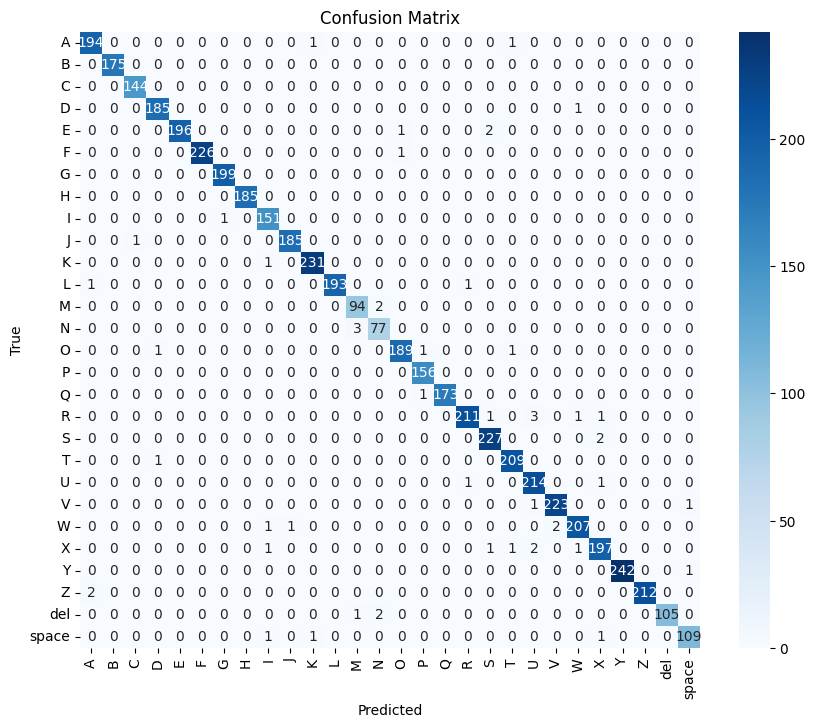

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
class_labels = [str(c) for c in le.classes_]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Tính tổng số nhầm lẫn giữa các cặp lớp (ngoại trừ đường chéo chính)

confused_pairs = []
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append(((class_labels[i], class_labels[j]), cm[i, j]))

# Sắp xếp giảm dần theo số lần nhầm lẫn
confused_pairs_sorted = sorted(confused_pairs, key=lambda x: x[1], reverse=True)

# Hiển thị top 10 cặp dễ nhầm lẫn nhất
print("Top các cặp từ dễ bị nhầm lẫn nhất:")
for (true_label, pred_label), count in confused_pairs_sorted[:10]:
    print(f"{true_label} ↔ {pred_label}: {count} lần")

Top các cặp từ dễ bị nhầm lẫn nhất:
N ↔ M: 3 lần
R ↔ U: 3 lần
E ↔ S: 2 lần
M ↔ N: 2 lần
S ↔ X: 2 lần
W ↔ V: 2 lần
X ↔ U: 2 lần
Z ↔ A: 2 lần
del ↔ N: 2 lần
A ↔ K: 1 lần
